# Building and Training a Convolutional Neural Network

**Goals:** Load the dataset, build and train a basic model, build a better
model using the technique of transfer learning.

**Summary:** The primary purpose of this notebook is to build a model 
that can classify a given house image. The dataset is balanced, so 'accuracy' 
is an appropriate evaluation metric. We summarize below our findings and 
the actions taken to achieve the stated goals.

1) **Load the Dataset:** We use the tensorflow.keras.preprocessing module
`image_dataset_from_directory` to load the training, validation, and test
datasets from our image collection. 


2) **Build and Train a Model:** As a first attempt, we build and train a
basic convolutional neural network. Since the training dataset is rather 
small, we include in the model a data augmentation layer. Unsurprisingly, 
the model does not perform well.


3) **Transfer Learning:** We use a pretrained 
[Xception](http://www.tensorflow.org/api_docs/python/tf/keras/applications/Xception)
model as a base model, adding on top of it a new classifier. We customize 
the base model in two ways:
 * **Feature Extraction:** Representations learned by the base model is 
used to extract meaningful features from the images in our dataset.
 * **Fine-Tuning:** Some of the top layers of the pretrained base model 
are unfreezed, and jointly trained along with a new classifier.

The final model is then evaluated on the test set.

In [1]:
# Load required packages and modules.
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
from tensorflow.keras import preprocessing, models, layers, optimizers
from tensorflow.keras import callbacks, metrics, applications, Model, Input
from tensorflow.python.util import deprecation
from sklearn.metrics import classification_report

# Suppress deprecation warnings.
deprecation._PRINT_DEPRECATION_WARNINGS = False

# Set the backend of matplotlib to 'inline'.
%matplotlib inline

# Create plots using seaborn's default aesthetic arguments. 
sns.set()

# Make this notebook's output identical across runs.
np.random.seed(1)
tf.random.set_seed(1)

## 1. Load the Dataset

In [2]:
# Path to the images.
DATA_DIR_PATH = pathlib.Path('/home/ubuntu/notebooks/house_classifier/data')
SPLITS_DIR_PATH = DATA_DIR_PATH.joinpath('splits')
TRAIN_DIR_PATH = SPLITS_DIR_PATH.joinpath('train')
VAL_DIR_PATH = SPLITS_DIR_PATH.joinpath('val')
TEST_DIR_PATH = SPLITS_DIR_PATH.joinpath('test')

Let's load the training dataset:

In [3]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256
SEED = 1

train_set = preprocessing.image_dataset_from_directory(
  TRAIN_DIR_PATH,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True,
  seed=SEED,  
  interpolation='bilinear'
)

Found 1569 files belonging to 6 classes.


Let's load the validation dataset:

In [4]:
val_set = preprocessing.image_dataset_from_directory(
  VAL_DIR_PATH,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True,
  seed=SEED,  
  interpolation='bilinear'
)

Found 312 files belonging to 6 classes.


Let's load the test dataset:

In [5]:
test_set = preprocessing.image_dataset_from_directory(
  TEST_DIR_PATH,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True,
  seed=SEED,  
  interpolation='bilinear'
)

Found 215 files belonging to 6 classes.


We note that the training set, the validation set, and the test set consist 
of roughly 75%, 15%, and 10% of all images, respectively.

What are the class names?

In [6]:
class_names = train_set.class_names
print(class_names)

['cape_cod', 'colonial', 'craftsman', 'mediterranean', 'ranch', 'tudor']


Let's verify that the training set, the validation set, and the test set 
contain roughly an equal number of images of each type:

In [7]:
datasets = {'Training Set': train_set, 
            'Validation Set': val_set, 
            'Test Set': test_set}

counts = {key: Counter() for key in datasets}

for key in datasets:  
    for _, labels in datasets[key]:
        label, count = np.unique(labels.numpy(), return_counts=True)
        label = [class_names[i] for i in label]
        counts[key] += Counter(dict(zip(label, count)))  
df = pd.DataFrame(counts).sort_index(axis='index')
print(df)

               Training Set  Validation Set  Test Set
cape_cod                261              52        36
colonial                261              52        36
craftsman               262              52        36
mediterranean           261              52        35
ranch                   262              52        36
tudor                   262              52        36


Let's take a look at some sample images:

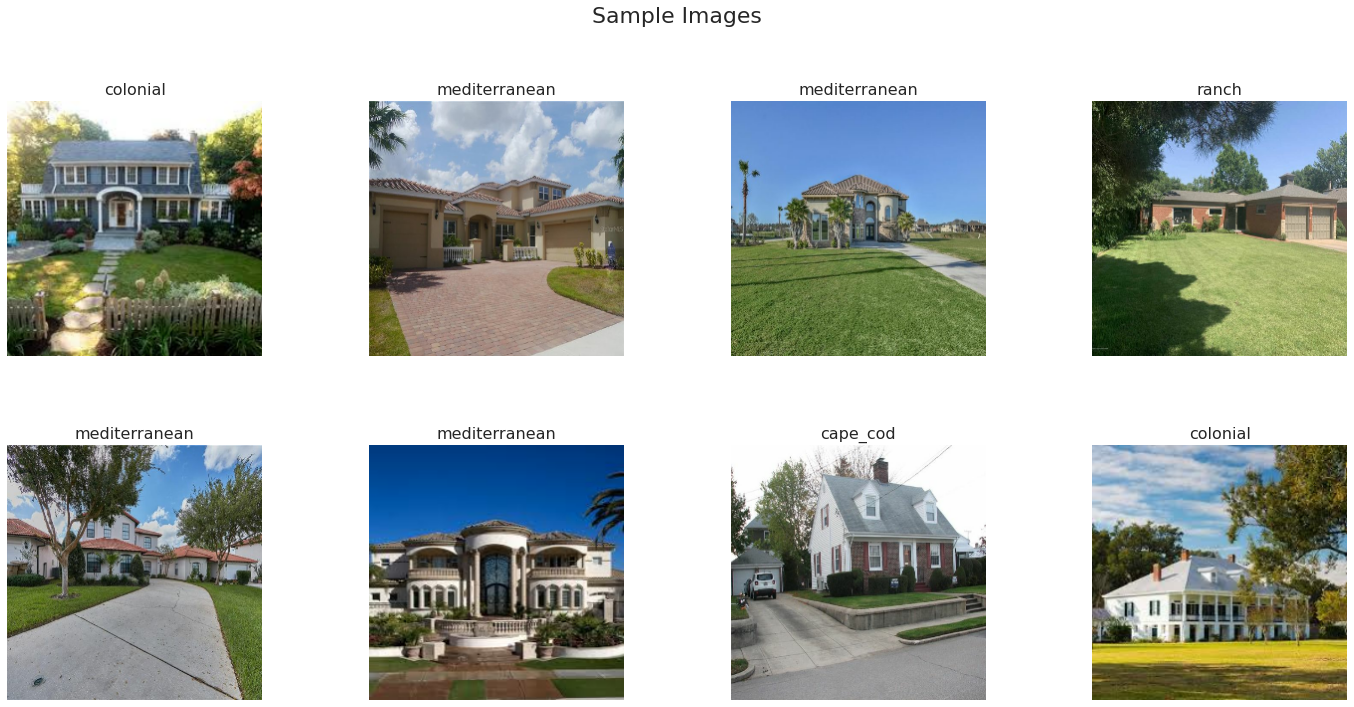

In [8]:
n_cols = 4
n_rows = 2
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
fig.suptitle('Sample Images', fontsize=22)
images, labels = next(iter(datasets['Training Set']))
for i in range(n_cols*n_rows):
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.imshow(images[i].numpy().astype('uint8')) 
    ax.set_title(class_names[labels[i]], fontsize=16)
    ax.axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.85, wspace=0.1, hspace=0.35) 

Let's configure the datasets for performance:

In [9]:
# Keep the images in memory after they are iterated over once.
for key in datasets:
    datasets[key] = datasets[key].cache()

# Overlap data preprocessing and model execution while training. While the 
# model is executing a training step, the input pipeline is reading the data 
# for the next step. Determine the number of elements to prefetch dynamically 
# at runtime.
AUTOTUNE = tf.data.experimental.AUTOTUNE
for key in datasets:
    datasets[key] = datasets[key].prefetch(AUTOTUNE)

## 2. Build and Train a Model

As a first attempt, let's build a basic convolutional neural network. Since 
our training dataset is small, we may benefit from augmenting our data. To 
this end, let's first create a data augmentation layer:

In [10]:
data_augmentation = models.Sequential()
data_augmentation.add(layers.experimental.preprocessing.RandomFlip(
    mode='horizontal', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
data_augmentation.add(layers.experimental.preprocessing.RandomRotation(0.025))
data_augmentation.add(layers.experimental.preprocessing.RandomZoom((-0.1, 0)))

Above, we are performing the following transformations on an input image:
* Randomly flip the image horizontally.

* Rotate the image by a random amount in the range 
$[-9^\circ, 9^\circ]$. 

* Zoom in by a random amount in the range $[0\%, 10\%]$.

In [11]:
data_augmentation.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 256, 256, 3)       0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Let's apply data augmentation to a single image several times, and visualize
the result:

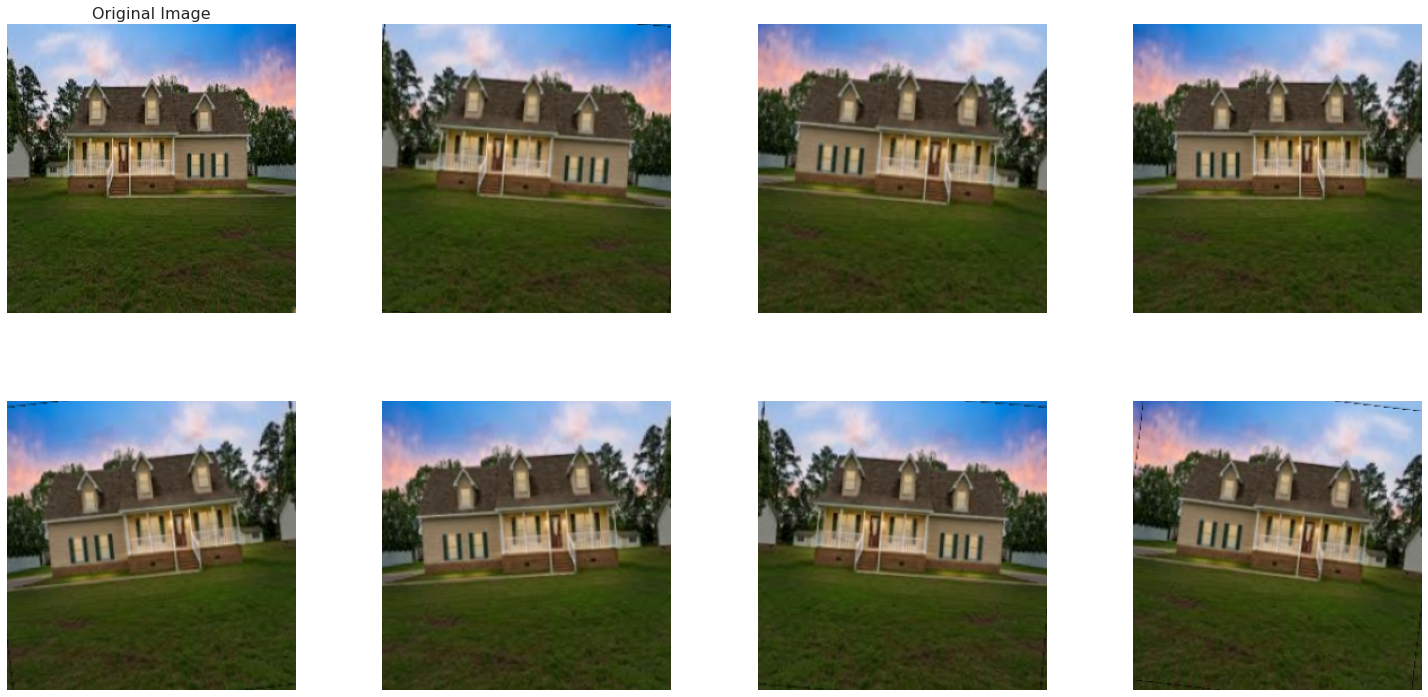

In [12]:
n_cols = 4
n_rows = 2
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
images, _  = next(iter(datasets['Training Set']))
ax = fig.add_subplot(n_rows, n_cols, 1)
ax.imshow(images[7].numpy().astype('uint8'))
ax.set_title('Original Image', fontsize=16)
ax.axis('off')
for i in range(n_cols*n_rows-1):
    augmented_images = data_augmentation(images)
    ax = fig.add_subplot(n_rows, n_cols, i+2)
    ax.imshow(augmented_images[7].numpy().astype('uint8'))         
    ax.axis('off')

fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.25)  

Let's build a convolutional neural network:

In [13]:
n_classes = len(class_names)

model_ini = models.Sequential()
model_ini.add(data_augmentation)
model_ini.add(layers.experimental.preprocessing.Rescaling(
                            scale=1/255, 
                            input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model_ini.add(layers.Conv2D(filters=16, 
                            kernel_size=(3, 3), 
                            padding='valid', 
                            activation='relu',
                            kernel_initializer='he_normal'))
model_ini.add(layers.BatchNormalization())
model_ini.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))
model_ini.add(layers.Conv2D(filters=32, 
                            kernel_size=(3, 3), 
                            padding='valid', 
                            activation='relu',
                            kernel_initializer='he_normal'))
model_ini.add(layers.BatchNormalization())
model_ini.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))
model_ini.add(layers.Conv2D(filters=64, 
                            kernel_size=(3, 3), 
                            padding='valid', 
                            activation='relu',
                            kernel_initializer='he_normal'))
model_ini.add(layers.BatchNormalization())
model_ini.add(layers.MaxPooling2D(pool_size=(2, 2), padding='valid'))
model_ini.add(layers.Flatten())
model_ini.add(layers.Dense(units=128, 
                           activation='relu',
                           kernel_initializer='he_normal'))
model_ini.add(layers.BatchNormalization())
model_ini.add(layers.Dropout(rate=0.3))
model_ini.add(layers.Dense(units=n_classes, activation='softmax'))

Some remarks about the network we just built:

* The first layer is the data augmentation layer. This layer is applied only 
during training, and not during inference.

* The second layer is a rescaling layer. This layer is applied both during 
training and inference.

* The next layer is a convolutional layer. We are using He initialization to 
mitigate the vanishing/exploding gradient problem that may occur at the 
beginning of training.

* The vanishing/exploding gradient problem can return during training, and
to mitigate this, we are adding a Batch Normalization layer after the 
activation function of each hidden layer. This technique was introduced
by Sergey Ioffe and Christian Szegedy in a 2015 paper. Batch Normalization 
also acts like a regularizer.

* We are downsampling the inputs using pooling layers. This reduces
the computational load and the number of parameters. The latter also helps 
limit the risk of overfitting.

* We added a dropoput layer to further mitigate overfitting.

* The number of filters in the convolutional layers grows as we move 
towards the output layer, since the number of low-level features is often 
small, but there are large number of ways to combine them into 
high-level features.

Let's compile the model:

In [14]:
# Bug alert: When `metrics=['accuracy']` is passed, tensorflow will choose 
# the appropriate accuracy method based on the selected loss function; in the 
# present case, the chosen accuracy method should be 
# 'sparse_categorical_accuracy', and it works as expected. However, if we
# save the model, and then reload it, tensorflow does not choose the
# correct accuracy method. As such, instead of passing 
# `metrics=['accuracy']`, we are passing 
# `metrics=['sparse_categorical_accuracy']`. This is a known bug, and it will 
# be fixed in the next release of tensorflow:
# https://github.com/tensorflow/tensorflow/issues/42459

n_batches = len(datasets['Training Set'])
s = int(n_batches/10)
model_ini.compile(optimizer=optimizers.SGD(learning_rate=0.1, 
                                           decay=1/s,
                                           momentum=0.9), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

A few words about the chosen hyperparameters:

* The size of Gradient Descent step is determined by the learning 
rate. We start with a large learning rate ($\eta_0 = 0.1$), and reduce it at 
each iteration.

* We are using power scheduling: For iteration $t$, the learning rate is
set to $\eta_0/(1 + t/s)$. The learning rate drops at each iteration.
After *s* iterations, the learning rate is down to $\eta_0/2$.
After *s* more iterations, it is down to $\eta_0/3$, and so on.
We have chosen *s* = n_batches/10, so that after 10% of the first epoch, the
learning rate is down to $\eta_0/2$, and so on.

* Momentum optimization helps escape from plateaus faster than ordinary 
Gradient Descent.

In [15]:
model_ini.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 254, 254, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 32)     

Let's create callbacks to save the model after each epoch, and to interrupt 
training when no progress is made on the validation set for 5 epochs:

In [16]:
model_checkpoint_cb = callbacks.ModelCheckpoint(
    'saved_models/house_classifier_ini', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_freq='epoch')
early_stopping_cb = callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    restore_best_weights=True)

In [17]:
%%time
n_epochs = 100
history_ini = model_ini.fit(
    datasets['Training Set'], 
    validation_data=datasets['Validation Set'], 
    epochs=n_epochs,
    verbose=1,
    callbacks=[model_checkpoint_cb, early_stopping_cb])

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 2.3034 - sparse_categorical_accuracy: 0.2213
Epoch 00001: val_loss improved from inf to 18.38775, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 410ms/step - loss: 2.3030 - sparse_categorical_accuracy: 0.2212 - val_loss: 18.3878 - val_sparse_categorical_accuracy: 0.1635
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 1.8423 - sparse_categorical_accuracy: 0.2793
Epoch 00002: val_loss improved from 18.38775 to 2.42710, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 19s 389ms/step - loss: 1.8422 - sparse_categorical_accuracy: 0.2792 - val_loss: 2.4271 - val_sparse_categorical_accuracy: 0.2372
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 392ms/step - loss: 1.5685 - sparse_categorical_accuracy: 0.3646 - val_loss: 1.5644 - val_sparse_categorical_accuracy: 0.3494
Epoch 20/100
49/50 [============================>.] - ETA: 0s - loss: 1.5305 - sparse_categorical_accuracy: 0.3827
Epoch 00020: val_loss improved from 1.56439 to 1.56404, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 395ms/step - loss: 1.5305 - sparse_categorical_accuracy: 0.3830 - val_loss: 1.5640 - val_sparse_categorical_accuracy: 0.3462
Epoch 21/100
49/50 [============================>.] - ETA: 0s - loss: 1.5415 - sparse_categorical_accuracy: 0.3890
Epoch 00021: val_loss improved from 1.56404 to 1.56276, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_i

Epoch 38/100
49/50 [============================>.] - ETA: 0s - loss: 1.5053 - sparse_categorical_accuracy: 0.4069
Epoch 00038: val_loss improved from 1.54202 to 1.53903, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 395ms/step - loss: 1.5054 - sparse_categorical_accuracy: 0.4073 - val_loss: 1.5390 - val_sparse_categorical_accuracy: 0.3590
Epoch 39/100
49/50 [============================>.] - ETA: 0s - loss: 1.5168 - sparse_categorical_accuracy: 0.3884
Epoch 00039: val_loss improved from 1.53903 to 1.53876, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 390ms/step - loss: 1.5169 - sparse_categorical_accuracy: 0.3888 - val_loss: 1.5388 - val_sparse_categorical_accuracy: 0.3526
Epoch 40/100
49/50 [============================>.] - ETA: 0s - lo

INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 397ms/step - loss: 1.4548 - sparse_categorical_accuracy: 0.4270 - val_loss: 1.5304 - val_sparse_categorical_accuracy: 0.3526
Epoch 57/100
49/50 [============================>.] - ETA: 0s - loss: 1.4754 - sparse_categorical_accuracy: 0.4126
Epoch 00057: val_loss improved from 1.53036 to 1.52990, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 394ms/step - loss: 1.4754 - sparse_categorical_accuracy: 0.4130 - val_loss: 1.5299 - val_sparse_categorical_accuracy: 0.3526
Epoch 58/100
49/50 [============================>.] - ETA: 0s - loss: 1.4649 - sparse_categorical_accuracy: 0.4349
Epoch 00058: val_loss improved from 1.52990 to 1.52879, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_i

50/50 [==============================] - 20s 392ms/step - loss: 1.4672 - sparse_categorical_accuracy: 0.4226 - val_loss: 1.5222 - val_sparse_categorical_accuracy: 0.3494
Epoch 75/100
49/50 [============================>.] - ETA: 0s - loss: 1.4895 - sparse_categorical_accuracy: 0.4062
Epoch 00075: val_loss improved from 1.52222 to 1.52137, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 19s 388ms/step - loss: 1.4895 - sparse_categorical_accuracy: 0.4066 - val_loss: 1.5214 - val_sparse_categorical_accuracy: 0.3590
Epoch 76/100
49/50 [============================>.] - ETA: 0s - loss: 1.4681 - sparse_categorical_accuracy: 0.4126
Epoch 00076: val_loss improved from 1.52137 to 1.52111, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 392ms/step - loss: 1.

INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 394ms/step - loss: 1.4559 - sparse_categorical_accuracy: 0.4264 - val_loss: 1.5180 - val_sparse_categorical_accuracy: 0.3558
Epoch 95/100
49/50 [============================>.] - ETA: 0s - loss: 1.4557 - sparse_categorical_accuracy: 0.4228
Epoch 00095: val_loss improved from 1.51801 to 1.51753, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_ini/assets
50/50 [==============================] - 20s 395ms/step - loss: 1.4558 - sparse_categorical_accuracy: 0.4232 - val_loss: 1.5175 - val_sparse_categorical_accuracy: 0.3558
Epoch 96/100
49/50 [============================>.] - ETA: 0s - loss: 1.4599 - sparse_categorical_accuracy: 0.4126
Epoch 00096: val_loss improved from 1.51753 to 1.51752, saving model to saved_models/house_classifier_ini
INFO:tensorflow:Assets written to: saved_models/house_classifier_i

If the early stopping callback is triggered, then the best weights of the 
model will get restored automatically, since we passed 
`restore_best_weights=True`. If not, we need to restore the best weights 
manually by loading the best saved model off the disk:

In [18]:
model_ini = models.load_model('saved_models/house_classifier_ini')

Let's define a function that plots loss and accuracy on the training and 
validation sets:

In [19]:
def plot_loss_and_accuracy(history_1, history_2=None):
    """Create plots of loss and accuracy on the training and validation sets.
        
    Parameters
    ----------
    history_1, history_2 : dictionaries, with values array-like of 
                           shape [n_epochs]
                           Loss and accuracy for each epoch.
    """ 
    loss = history_1['loss'].copy()
    acc = history_1['sparse_categorical_accuracy'].copy()
    val_loss = history_1['val_loss'].copy()
    val_acc = history_1['val_sparse_categorical_accuracy'].copy()   

    n_epochs = len(history_1['loss'])
    epochs_range = range(1, n_epochs+1, 1)
    
    if history_2:
        loss += history_2['loss']
        acc += history_2['sparse_categorical_accuracy']
        val_loss += history_2['val_loss']
        val_acc += history_2['val_sparse_categorical_accuracy']  
        n_epochs += len(history_2['loss'])
        epochs_range = range(1, n_epochs+1, 1)

    n_cols = 2
    n_rows = 1
    aspect = 1.5
    fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
    ax1 = fig.add_subplot(n_rows, n_cols, 1)
    ax1.plot(epochs_range, loss, label='Training Loss')
    ax1.plot(epochs_range, val_loss, label='Validation Loss')
    if history_2:
        ax1.axvline(x=len(history_1['loss']), ymin=0, 
                    ymax=ax1.get_ylim()[1], linestyle='--', linewidth=2, 
                    color='green', alpha=0.5, label='Start Fine-Tuning')
    ax1.legend(loc='best')
    ax1.set_xlabel('Epochs', fontsize=16)
    ax1.set_ylabel('Loss', fontsize=16)
    ax1.set_title('Training and Validation Loss', fontsize=22)

    ax2 = fig.add_subplot(n_rows, n_cols, 2)
    ax2.plot(epochs_range, acc, label='Training Accuracy')
    ax2.plot(epochs_range, val_acc, label='Validation Accuracy')
    if history_2:
        ax2.axvline(x=len(history_1['loss']), ymin=0, ymax=1,
                    linestyle='--', linewidth=2, color='green', alpha=0.5,
                    label='Start Fine-Tuning')
    ax2.legend(loc='best')
    ax2.set_xlabel('Epochs', fontsize=16)
    ax2.set_ylabel('Accuracy', fontsize=16)
    ax2.set_title('Training and Validation Accuracy', fontsize=22)

    fig.tight_layout()
    fig.subplots_adjust(wspace=0.2)   

Let's take a look at the learning curves of loss and accuracy on the 
training and validation sets:

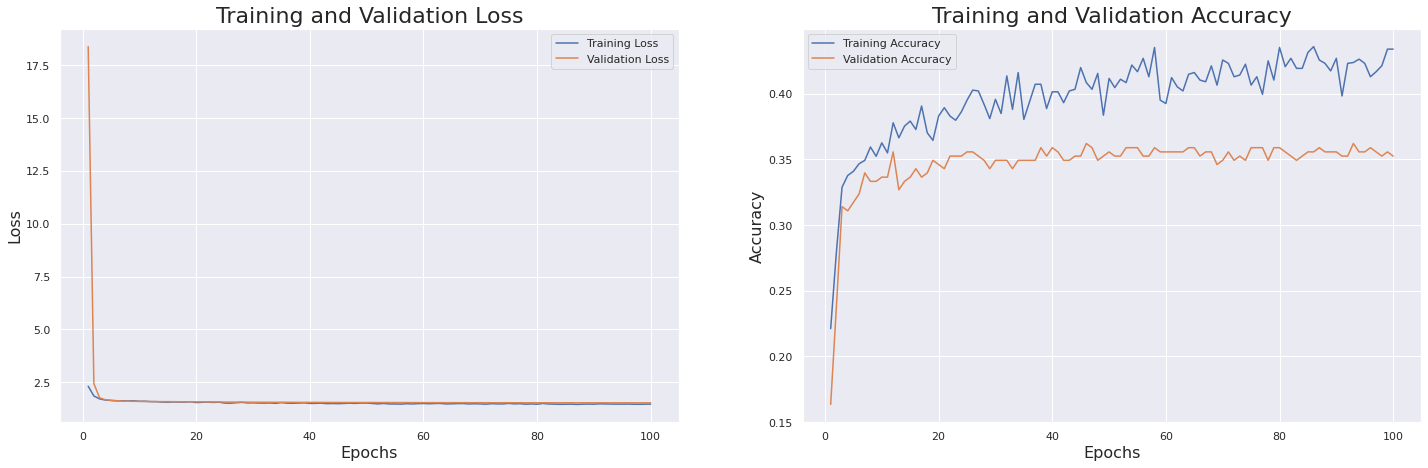

In [20]:
plot_loss_and_accuracy(history_ini.history)

The accuracy graph above shows a clear sign of overfitting, which was to be 
expected given that our training dataset is small.

Let's gather the true labels for the training, validation, and test sets:

In [21]:
true_labels = {'Training Set': [], 
               'Validation Set': [], 
               'Test Set': []}
for key in true_labels:
    for _, labels in datasets[key]:
        true_labels[key].extend(labels.numpy())

Let's gather the initial model's predicted probabilities for the training, 
validation, and test sets:

In [22]:
probas_ini = {'Training Set': None, 
              'Validation Set': None, 
              'Test Set': None}
# Since each dataset has been cached, the ordering of the examples in each
# dataset when calling `predict` is identical to the corresponding ordering 
# in `true_labels`.
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
for key in probas_ini:
    probas_ini[key] = model_ini.predict(datasets[key])

Let's define a function that prints the Top-k accuracy score:

In [23]:
def top_k_accuracy(y_true, y_probas, ks=[1]):
    """Print Top-k accuracy score for the given true labels and predicted
    probabilities.
        
    Parameters
    ----------
    y_true : dictionary with array-like values of shape [n_samples]
             True binary labels. 
        
    y_probas : dictionary with array-like values of shape 
               [n_samples, n_classes]
               Predicted probabilities.     
               
    ks: list, default [1]
        k values to consider.              
    """ 
    scores = {key: [] for key in y_probas}
    for key in scores:
        for k in ks:
            metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k)
            metric.update_state(y_true[key], y_probas[key])
            acc = metric.result().numpy()
            acc = round(acc, 4)
            scores[key].append(acc)
    df = pd.DataFrame(scores, index=pd.Index(ks, name='k'))
    print(df)

Let's take a look at the initial model's Top-k accuracy scores for the 
training, validation, and test sets:

In [24]:
top_k_accuracy(true_labels, probas_ini, ks=[1, 2, 3])

   Training Set  Validation Set  Test Set
k                                        
1        0.4710          0.3558    0.3302
2        0.6973          0.6474    0.5767
3        0.8305          0.7949    0.7302


Let's take a look at the precision, recall, and F1-scores for our initial 
model on the test set:

In [25]:
print(classification_report(true_labels['Test Set'], 
                            np.argmax(probas_ini['Test Set'], axis=-1),
                            target_names=class_names,
                            zero_division=0))

               precision    recall  f1-score   support

     cape_cod       0.18      0.11      0.14        36
     colonial       0.32      0.33      0.32        36
    craftsman       0.32      0.17      0.22        36
mediterranean       0.28      0.31      0.30        35
        ranch       0.48      0.64      0.55        36
        tudor       0.31      0.42      0.35        36

     accuracy                           0.33       215
    macro avg       0.31      0.33      0.31       215
 weighted avg       0.31      0.33      0.31       215



Unsurprisingly, the model does not perform well.

## 3. Transfer Learning

Since our training dataset is rather small, we may benefit from using the 
technique of *transfer learning*, in which a model developed for one task
is used as the base for a model on a second task.

We will use as our base model a pretrained Xception model, 
developed for the [*ImageNet Large Scale Visual Recognition Challenge*](http://www.image-net.org/challenges/LSVRC),
and trained on a dataset consisting of more than a million images.
The pretrained model classifies a input image into one of 1000 diverse 
[categories](http://image-net.org/challenges/LSVRC/2017/browse-synsets), 
such as sea lion and tractor. The Xception model was proposed in 2016 by 
François Chollet, the author of Keras. 

Let's load the Xception model, omitting the last layer of the model which 
makes predictions about the 1000 classes:

In [26]:
base_model = applications.xception.Xception(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    weights='imagenet',
    include_top=False)

Let's take a look at the architecture of the Xception model:

In [27]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

We will customize the pretrained base model in two ways:

* **Feature Extraction:** We will use the representations learned by the 
pretrained base model to extract meaningful features from our house 
images. To this end, we will simply add on top of the base model a new 
classifier, which will be trained from scratch. We will not train the 
entire model. The pretrained base model has already learned feature
representations that are generically useful for classifying images, so 
it does not need to be train. Only the new classifier, which is specific 
to our current classification task, need to be trained. 


* **Fine-Tuning:** We will unfreeze some of the top layers of the 
pretrained base model, and jointly train it along with the new 
classifier. This allows us to fine-tune some of the higher-order feature 
representations learned by the base model, making it more relevant for 
our present task of classifying house images.

Let's freeze the base model:

In [28]:
base_model.trainable = False

Let's build a model using Xception as the base:

In [29]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(rate=0.3)(x)
outputs = layers.Dense(units=n_classes, activation='softmax')(x)
model_xcp = Model(inputs, outputs)

Some remarks about the network we just built:

* The first layer is the data augmentation layer we defined earlier.

* Next is the Xception preprocess layer, and then comes the pretrained 
Xception model. We are passing `training=False` when calling the base model 
to ensure that it runs in inference mode. The reason for this is that the 
base model contains batch normalization layers, and we want to keep these
in inference mode when we unfreeze the base model for fine-tuning.
Keeping the batch normalization layers in inference mode will ensure that 
the batch normalization statistics don't get updated during fine-tuning. 

* We added a dropoput layer to mitigate overfitting, which can be severe
especially during fine-tuning.

* The output layer is a dense layer consiting of 6 units (number of classes
in our classification problem), with softmax activation.

In [30]:
s = int(n_batches/10)
model_xcp.compile(optimizer=optimizers.SGD(learning_rate=0.1, 
                                           decay=1/s,
                                           momentum=0.9), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [31]:
model_xcp.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [32]:
model_checkpoint_cb_xcp_1 = callbacks.ModelCheckpoint(
    'saved_models/house_classifier_xcp_1',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_freq='epoch')

Let's train the new classifier that was added on top of the base model:

In [33]:
%%time
n_initial_epochs = 100
history_xcp_1 = model_xcp.fit(
    datasets['Training Set'], 
    validation_data=datasets['Validation Set'], 
    epochs=n_initial_epochs,
    verbose=1,
    callbacks=[model_checkpoint_cb_xcp_1, early_stopping_cb])

Epoch 1/100
49/50 [============================>.] - ETA: 0s - loss: 1.1008 - sparse_categorical_accuracy: 0.5969
Epoch 00001: val_loss improved from inf to 0.83993, saving model to saved_models/house_classifier_xcp_1
INFO:tensorflow:Assets written to: saved_models/house_classifier_xcp_1/assets
50/50 [==============================] - 51s 1s/step - loss: 1.1001 - sparse_categorical_accuracy: 0.5972 - val_loss: 0.8399 - val_sparse_categorical_accuracy: 0.6891
Epoch 2/100
49/50 [============================>.] - ETA: 0s - loss: 0.7824 - sparse_categorical_accuracy: 0.7111
Epoch 00002: val_loss improved from 0.83993 to 0.79350, saving model to saved_models/house_classifier_xcp_1
INFO:tensorflow:Assets written to: saved_models/house_classifier_xcp_1/assets
50/50 [==============================] - 50s 1s/step - loss: 0.7819 - sparse_categorical_accuracy: 0.7113 - val_loss: 0.7935 - val_sparse_categorical_accuracy: 0.6955
Epoch 3/100
49/50 [============================>.] - ETA: 0s - loss: 0

As stated earlier, the best weights of the model don't get restored 
automatically if the early stopping callback is not triggered, so we do this
manually:

In [34]:
model_xcp = models.load_model('saved_models/house_classifier_xcp_1')

Let's take a look at the learning curves of loss and accuracy on the 
training and validation sets when using the Xception base model as a 
frozen feature extractor:

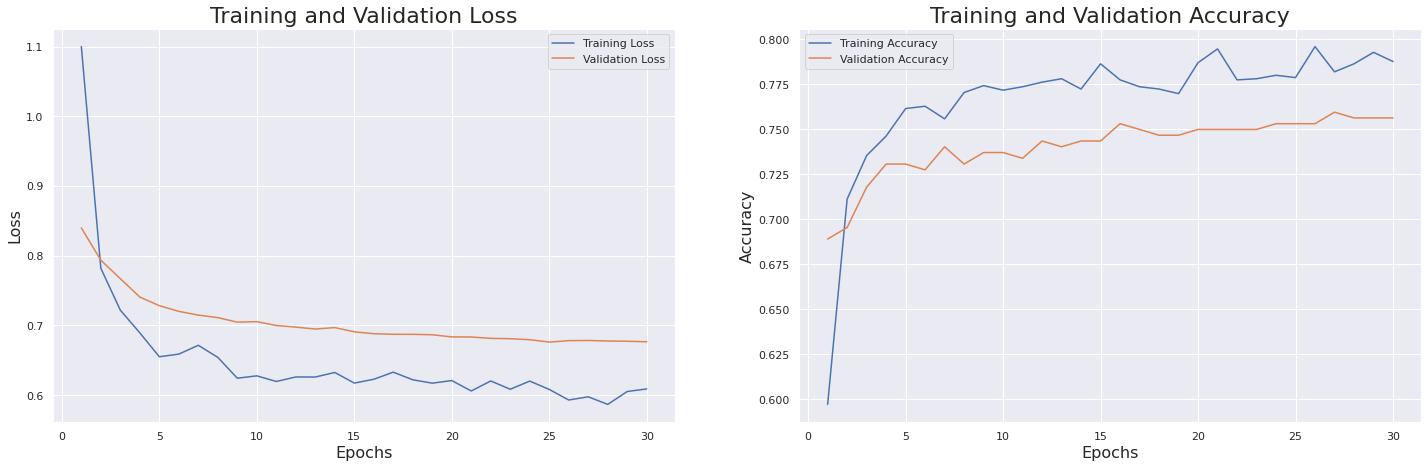

In [35]:
plot_loss_and_accuracy(history_xcp_1.history)

Let's gather the model's predicted probabilities for the training, 
validation, and test sets:

In [36]:
probas_xcp_1 = {'Training Set': None, 
                'Validation Set': None, 
                'Test Set': None}
for key in probas_xcp_1:
    probas_xcp_1[key] = model_xcp.predict(datasets[key])

Let's take a look at the model's Top-k accuracy scores for the training, 
validation, and test sets:

In [37]:
top_k_accuracy(true_labels, probas_xcp_1, ks=[1, 2, 3])

   Training Set  Validation Set  Test Set
k                                        
1        0.7967          0.7532    0.7767
2        0.9286          0.9199    0.9116
3        0.9771          0.9679    0.9674


Let's take a look at the precision, recall, and F1-scores for the model on 
the test set:

In [38]:
print(classification_report(true_labels['Test Set'], 
                            np.argmax(probas_xcp_1['Test Set'], axis=-1),
                            target_names=class_names,
                            zero_division=0))

               precision    recall  f1-score   support

     cape_cod       0.71      0.61      0.66        36
     colonial       0.74      0.56      0.63        36
    craftsman       0.77      0.83      0.80        36
mediterranean       0.94      0.94      0.94        35
        ranch       0.71      0.89      0.79        36
        tudor       0.79      0.83      0.81        36

     accuracy                           0.78       215
    macro avg       0.78      0.78      0.77       215
 weighted avg       0.78      0.78      0.77       215



Next, it's time for fine-tuning: Train some of the top layers of the 
pretrained base model jointly with the classifier layer. 

Let's unfreeze the base model:

In [39]:
base_model = model_xcp.get_layer('xception')
base_model.trainable = True

How many layers does the base model have?

In [40]:
print('Number of layers in the base model: ', len(base_model.layers))

Number of layers in the base model:  132


We will fine-tune the top 30 layers:

In [41]:
# Fine-tune from this layer onwards.
fine_tune_at = 102

# Freeze all the layers below the `fine_tune_at` layer.
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Even though some layers of the base model have now becomes trainable, the
base model will still run in inference mode for reasons explained earlier.

Since we are now training a much larger model and tweeking the pretrained 
weights, we will use a lower learning rate:

In [42]:
s = int(n_batches/10)
model_xcp.compile(optimizer=optimizers.SGD(learning_rate=0.01, 
                                           decay=1/s,
                                           momentum=0.9), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

In [43]:
model_xcp.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF (None, 256, 256, 3)       0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO (None, 256, 256, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [44]:
model_checkpoint_cb_xcp_2 = callbacks.ModelCheckpoint(
    'saved_models/house_classifier_xcp_2',
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_freq='epoch')

In [45]:
%%time
n_fine_tune_epochs = 100
total_epochs = n_initial_epochs + n_fine_tune_epochs
history_xcp_2 = model_xcp.fit(
    datasets['Training Set'], 
    validation_data=datasets['Validation Set'], 
    epochs=total_epochs,
    initial_epoch=history_xcp_1.epoch[-1]+1,
    verbose=1,
    callbacks=[model_checkpoint_cb_xcp_2, early_stopping_cb])

Epoch 31/200
50/50 [==============================] - ETA: 0s - loss: 0.4480 - sparse_categorical_accuracy: 0.8458
Epoch 00031: val_loss improved from inf to 0.45085, saving model to saved_models/house_classifier_xcp_2
INFO:tensorflow:Assets written to: saved_models/house_classifier_xcp_2/assets
50/50 [==============================] - 64s 1s/step - loss: 0.4480 - sparse_categorical_accuracy: 0.8458 - val_loss: 0.4509 - val_sparse_categorical_accuracy: 0.8333
Epoch 32/200
50/50 [==============================] - ETA: 0s - loss: 0.2519 - sparse_categorical_accuracy: 0.9076
Epoch 00032: val_loss improved from 0.45085 to 0.38110, saving model to saved_models/house_classifier_xcp_2
INFO:tensorflow:Assets written to: saved_models/house_classifier_xcp_2/assets
50/50 [==============================] - 64s 1s/step - loss: 0.2519 - sparse_categorical_accuracy: 0.9076 - val_loss: 0.3811 - val_sparse_categorical_accuracy: 0.8782
Epoch 33/200
50/50 [==============================] - ETA: 0s - loss

In [46]:
# Restore the best weights of the model in case the early stopping callback 
# is not triggered.
model_xcp = models.load_model('saved_models/house_classifier_xcp_2')

Let's take a look at the learning curves of loss and accuracy on the 
training and validation sets when fine-tuning the top layers of the Xception 
base model and the new classifier:

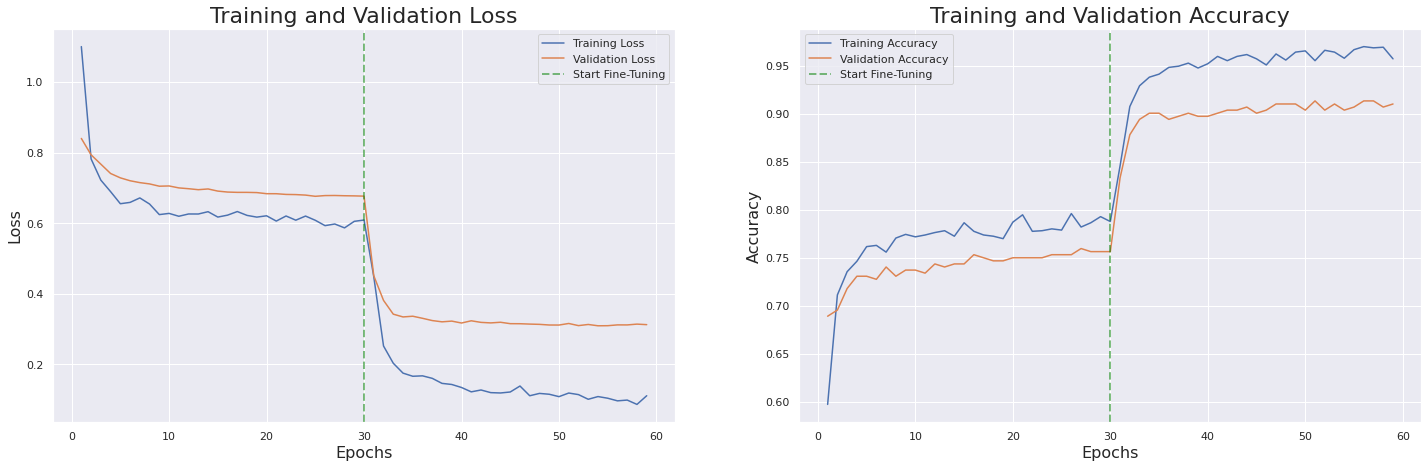

In [47]:
plot_loss_and_accuracy(history_xcp_1.history, history_xcp_2.history)

Let's gather the model's predicted probabilities for the training, 
validation, and test sets:

In [48]:
probas_xcp_2 = {'Training Set': None, 
                'Validation Set': None, 
                'Test Set': None}
for key in probas_xcp_2:
    probas_xcp_2[key] = model_xcp.predict(datasets[key])

Let's take a look at the model's Top-k accuracy scores for the training, 
validation, and test sets:

In [49]:
top_k_accuracy(true_labels, probas_xcp_2, ks=[1, 2, 3])

   Training Set  Validation Set  Test Set
k                                        
1        0.9720          0.9038    0.9256
2        0.9949          0.9776    0.9860
3        0.9994          0.9936    0.9953


We highlight that our final model achieves a Top-1 accuracy rate of 
approximately 93% on the test set. 

Let's take a look at the precision, recall, and F1-scores for the model on 
the test set:

In [50]:
print(classification_report(true_labels['Test Set'], 
                            np.argmax(probas_xcp_2['Test Set'], axis=-1),
                            target_names=class_names,
                            zero_division=0))

               precision    recall  f1-score   support

     cape_cod       0.94      0.83      0.88        36
     colonial       0.91      0.89      0.90        36
    craftsman       0.89      0.94      0.92        36
mediterranean       0.97      0.94      0.96        35
        ranch       0.85      0.97      0.91        36
        tudor       1.00      0.97      0.99        36

     accuracy                           0.93       215
    macro avg       0.93      0.93      0.93       215
 weighted avg       0.93      0.93      0.93       215



Let's create and visualize the confusion matrix for the test set:

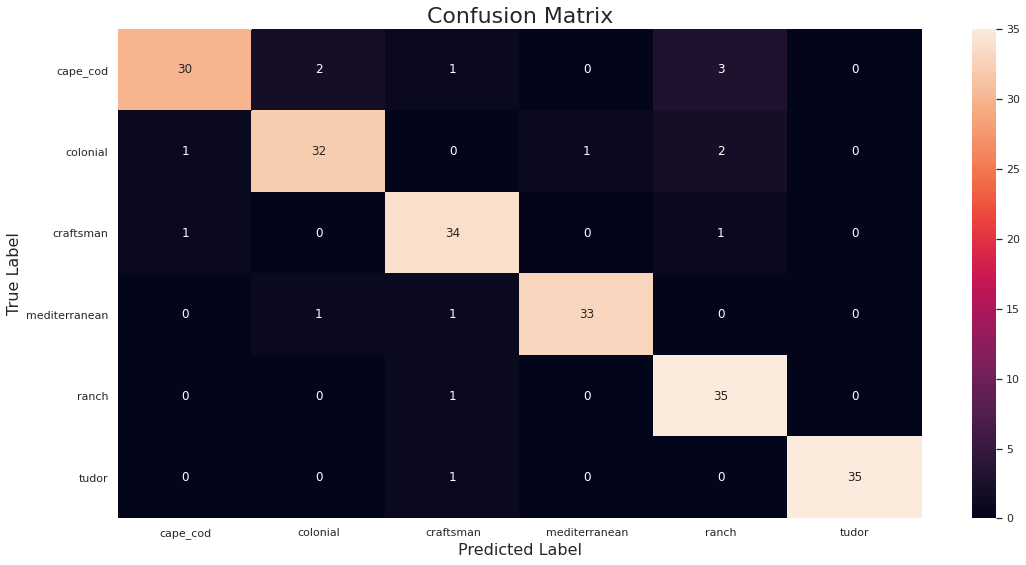

In [51]:
confusion_mtx = tf.math.confusion_matrix(
    labels=true_labels['Test Set'], 
    predictions=np.argmax(probas_xcp_2['Test Set'], axis=-1))

fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(confusion_mtx, xticklabels=class_names, yticklabels=class_names, 
            annot=True, fmt='d', ax=ax)
ax.set_xlabel('Predicted Label', fontsize=16)
ax.set_ylabel('True Label', fontsize=16)
ax.set_title('Confusion Matrix', fontsize=22);      

From the confusion matrix above, we see that the model has the most trouble 
classifying Cape Cod type houses, being accurately predicted only 83% of 
the time.

Finally, let's use our model to classify an image that wasn't included in the 
training or validation sets:

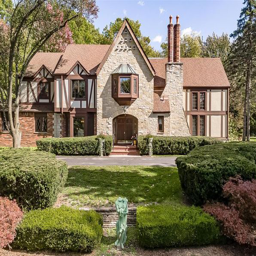

In [52]:
example_path = TEST_DIR_PATH.joinpath('tudor/254.jpeg')
example = Image.open(example_path)
example = example.resize((256, 256))
example

In [53]:
def prepare_image(image_path, target_size):    
    image = preprocessing.image.load_img(image_path, 
                                         color_mode='rgb',
                                         target_size=target_size,
                                         interpolation='bilinear')        
    image_array = preprocessing.image.img_to_array(image)
    image_array = tf.expand_dims(image_array, axis=0)    
    return image_array

example_array = prepare_image(example_path, (IMG_WIDTH, IMG_HEIGHT))

In [54]:
example_proba = model_xcp.predict(example_array).tolist()[0]
example_proba = [(i, example_proba[i]) for i in range(0, n_classes, 1)]
example_proba = [(class_names[i], j) for i, j 
                 in sorted(example_proba,
                           key=lambda item: item[1],
                           reverse=True)]
print((f'The model predicts that the given image most likely belongs to the '
       f'{example_proba[0][0]} class of house.\n'))
print('Predicted probabilities')
print('-----------------------')
for item in example_proba:
    print(f'{item[0]}: {round(100*item[1], 2)}%')

The model predicts that the given image most likely belongs to the tudor class of house.

Predicted probabilities
-----------------------
tudor: 99.93%
craftsman: 0.07%
colonial: 0.0%
cape_cod: 0.0%
mediterranean: 0.0%
ranch: 0.0%
